# DTSA-5511:  Week 6 - Final Project

## Crowd Detection and Count Prediction Using CSRNet

## Part 1: Brief Description of the Problem and Data 

This project involves taking an image of a crowd and being able to calculate the number of people in the image. The crowds can be small everyday groupings (ie city street, office) and large crowds (ie rock concert, sporting event). In order to perform this task, a CSRNet will be our model of choice. This model will make use of transfer learning to combine the frontend of a VGG16 model with a customized backend to achieve our desired results.

The data consists of nearly 3.34GB of image and spatial data. The images are divided into two folders: pictures of large crowds and pictures of smaller everyday simple everyday crowds. Each of these two folders contains their own training and testing datasets. The imagery is in the JPG file format. The spatial data is in the MAT file format. These files contain coordinates to individual points in a paired image where a person has been identified. 

Please note that Part 6 of this notebook contains all references to code that was used to build this project.

Dataset:
https://www.kaggle.com/datasets/tthien/shanghaitech

CSRNet Research Paper:
https://openaccess.thecvf.com/content_cvpr_2018/papers/Li_CSRNet_Dilated_Convolutional_CVPR_2018_paper.pdf

In [1]:
# The below code is implemented simply to supress warnings when running this model on my system.

def import_tensorflow():
    # Filter tensorflow version warnings
    import os
    # https://stackoverflow.com/questions/40426502/is-there-a-way-to-suppress-the-messages-tensorflow-prints/40426709
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
    import warnings
    # https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning
    warnings.simplefilter(action = 'ignore', category = FutureWarning)
    warnings.simplefilter(action = 'ignore', category = Warning)
    import tensorflow as tf
    tf.get_logger().setLevel('INFO')
    tf.autograph.set_verbosity(0)
    import logging
    tf.get_logger().setLevel(logging.ERROR)
    return tf

tf = import_tensorflow()   

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import h5py
import scipy.io as io
import scipy
import json
import os
import glob
import random
import math
import sys
import PIL

from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
from matplotlib import cm as CM
from PIL import Image

from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import model_from_json
from keras.initializers import RandomNormal
#from keras.applications.vgg16 import VGG16
from keras.models import Model, Sequential
from keras import backend as K
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Activation, ReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [3]:
print(f"TensorFlow version = {tf.__version__}\n")

TensorFlow version = 2.12.0



In [4]:
# Detect the presence of the GPU on this system. Also limit the memory growth to avoid having the model consume all the system memory.

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print("NVidia CUDA GPU information:\n")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        print(gpus)
        print("\n")
        #!nvidia-smi
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

NVidia CUDA GPU information:

1 Physical GPUs, 1 Logical GPUs
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]




## Part 2: Exploratory Data Analysis (EDA)

Connect the model to the data directories on this system.

In [5]:
root = 'data'
large_crowd_train = os.path.join(root, 'large_crowd/train_data','images')
large_crowd_test = os.path.join(root, 'large_crowd/test_data','images')
small_crowd_train = os.path.join(root, 'small_crowd/train_data','images')
small_crowd_test = os.path.join(root, 'small_crowd/test_data','images')
path_sets = [large_crowd_train, large_crowd_test, small_crowd_train, small_crowd_test]

Now let us look at the total number of images in all the folders.

In [6]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)
print(len(img_paths))

1198


The MAT formal file is a dictionary of various values. Of importance to us is the "image_info" dictionary key. These are a series of x-y coordinates that show the location of individual persons in the image. This will thus be needed to train our model.

In [7]:
mat =  io.loadmat(root + '/large_crowd/train_data/ground-truth/GT_IMG_10.mat')
print(mat)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Nov 18 20:06:05 2016', '__version__': '1.0', '__globals__': [], 'image_info': array([[array([[(array([[ 855.32345978,  590.49587357],
                       [ 965.5908524 ,  472.79472415],
                       [ 937.09478464,  400.93507502],
                       ...,
                       [  42.5852337 ,  359.87860699],
                       [1017.48233659,    8.99748811],
                       [1017.48233659,   23.31916643]]), array([[920]], dtype=uint16))]],
              dtype=[('location', 'O'), ('number', 'O')])                                ]],
      dtype=object)}


Now let us take a look at two example images:

1. This first image was from the imagery set of big crowds. As can be easily observed, there are a lot of individual people present in this scene (quite possibly well over 100 people).
2. This second image is from the small crowds imagery set. Though still many people, you could if you wish quickly do a head count of people in this image.

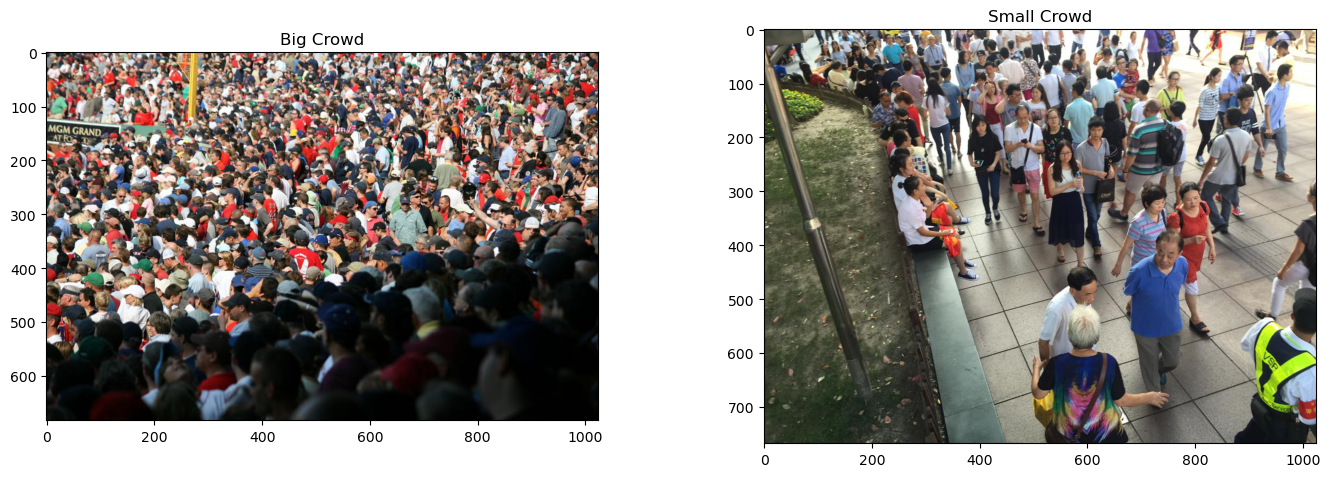

In [8]:
img1 = Image.open(root + '/large_crowd/train_data/images/IMG_10.jpg')
img2 = Image.open(root + '/small_crowd/train_data/images/IMG_20.jpg')
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 2)
figure.tight_layout(pad = 2)
figure.set_figheight(15)
figure.set_figwidth(15)
axis[0].set_title("Big Crowd")
axis[0].imshow(img1)
axis[1].set_title("Small Crowd")
axis[1].imshow(img2)

What can also been seen from the above two images is that each have different resolutions. Doing a quick check of 5 random images, you can see that the differing resoltions. 

This is a problem. Keras does not allow variable size inputs (ie variable resoltions) to be trained in the same batch. We will need to resolve this before beginning our model training. 

In [9]:
randomlist = []
for i in range(0,5):
    n = random.randint(1,99)
    randomlist.append(n)

im1 = cv2.imread(large_crowd_train + '/IMG_' + str(randomlist[0]) + '.jpg')
print(f"The shape of IMG_{randomlist[0]} = {im1.shape}")

im2 = cv2.imread(large_crowd_train + '/IMG_' + str(randomlist[1]) + '.jpg')
print(f"The shape of IMG_{randomlist[1]} = {im2.shape}")

im3 = cv2.imread(large_crowd_train + '/IMG_' + str(randomlist[2]) + '.jpg')
print(f"The shape of IMG_{randomlist[2]} = {im3.shape}")

im4 = cv2.imread(large_crowd_train + '/IMG_' + str(randomlist[3]) + '.jpg')
print(f"The shape of IMG_{randomlist[3]} = {im4.shape}")

im5 = cv2.imread(large_crowd_train + '/IMG_' + str(randomlist[4]) + '.jpg')
print(f"The shape of IMG_{randomlist[4]} = {im5.shape}")#'''

The shape of IMG_20 = (688, 1024, 3)
The shape of IMG_90 = (576, 1024, 3)
The shape of IMG_51 = (656, 1024, 3)
The shape of IMG_70 = (768, 1024, 3)
The shape of IMG_84 = (435, 1024, 3)


Function to generates a density map using Gaussian filter transformation. The Gaussian distribution basically calculates the probability that the observed object is actually a head and should be counted. 

In [10]:
def gaussian_filter_density(gt):
        
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt) 
    if gt_count == 0:
        return density

    # Find out the K nearest neighbours using a KDTree
    pts = np.array(list(zip(np.nonzero(gt)[1].ravel(), np.nonzero(gt)[0].ravel())))
    leafsize = 2048
    
    # Build KdTree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize = leafsize)
    
    # Query the KDTree
    distances, locations = tree.query(pts, k=4)

    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype = np.float32)
        pt2d[pt[1], pt[0]] = 1.0
        if gt_count > 1:
            sigma = (distances[i][1] + distances[i][2] + distances[i][3]) * 0.1
        else:
            sigma = np.average(np.array(gt.shape)) / 2.0 /2.0 #case: 1 point
        
        # Convolve with the gaussian filter
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode = 'constant')
    
    return density

This is the key function in our data preparation. This code will convert the ground truth files (MAT files) into density maps. For a given image, the MAT files provided a sparse matrix consisting of the literal head counts. This sparse matrix was converted into a 2D density map by passing through a Gaussian Filter. The sum of all the cells in the density map results in the actual count of people in that particular image.

This loop wil convert the images to h5 files and save them to the local disk. Once this is run one time you will not need to run it again since the local files can be used. This is the reason the below code is commented out.

Another important note is that this loop takes a very long time to run. On the machine used to test this code it took over 6 hours. 

In [11]:
'''
i = 0

for img_path in tqdm(img_paths):
        
    # Load sparse matrix
    mat = io.loadmat(img_path.replace('.jpg', '.mat').replace('images', 'ground-truth').replace('IMG_', 'GT_IMG_'))
    
    # Read image
    img= plt.imread(img_path)
    
    # Create a zero matrix of image size
    k = np.zeros((img.shape[0], img.shape[1]))
    
    gt = mat["image_info"][0,0][0,0][0]
    
    # Generate hot encoded matrix of sparse matrix
    for i in range(0, len(gt)):
        if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
            k[int(gt[i][1]), int(gt[i][0])] = 1
    
    # generate density map
    k = gaussian_filter_density(k)
    
    # File path to save density map
    file_path = img_path.replace('.jpg', '.h5').replace('images', 'ground-truth')
        
    with h5py.File(file_path, 'w') as hf:
            hf['density'] = k
'''

'\ni = 0\n\nfor img_path in tqdm(img_paths):\n        \n    # Load sparse matrix\n    mat = io.loadmat(img_path.replace(\'.jpg\', \'.mat\').replace(\'images\', \'ground-truth\').replace(\'IMG_\', \'GT_IMG_\'))\n    \n    # Read image\n    img= plt.imread(img_path)\n    \n    # Create a zero matrix of image size\n    k = np.zeros((img.shape[0], img.shape[1]))\n    \n    gt = mat["image_info"][0,0][0,0][0]\n    \n    # Generate hot encoded matrix of sparse matrix\n    for i in range(0, len(gt)):\n        if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:\n            k[int(gt[i][1]), int(gt[i][0])] = 1\n    \n    # generate density map\n    k = gaussian_filter_density(k)\n    \n    # File path to save density map\n    file_path = img_path.replace(\'.jpg\', \'.h5\').replace(\'images\', \'ground-truth\')\n        \n    with h5py.File(file_path, \'w\') as hf:\n            hf[\'density\'] = k\n'

We have now generated our density maps. Let us take a look at an example from our large crowd dataset. You can observe that the map appears to show greater density from where the crowd is furthest away. This makes sense due to scale. Objects, or in this case people, obviously appear smaller the further away they are. People at a further distance will be much more densily packed in regards to the 2D image. 

Sum = 405.7811279296875



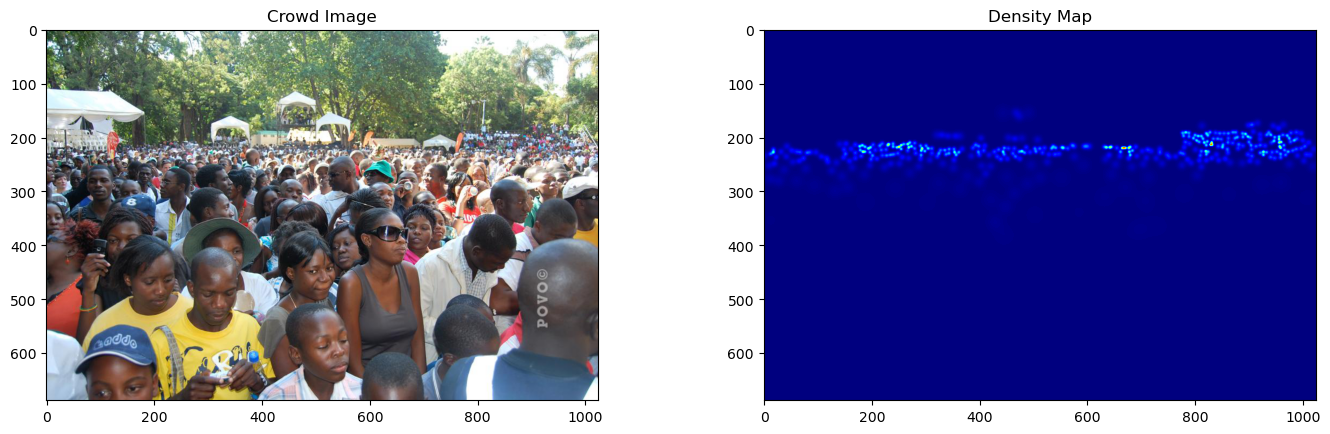

In [12]:
file_path = img_paths[29].replace('.jpg', '.h5').replace('images', 'ground-truth') 

gt_file = h5py.File(file_path, 'r')
groundtruth = np.asarray(gt_file['density'])
print(f"Sum = {np.sum(groundtruth)}\n")

img = Image.open(file_path.replace('.h5', '.jpg').replace('ground-truth', 'images'))

figure, axis = plt.subplots(1, 2)
figure.tight_layout(pad = 2)
figure.set_figheight(15)
figure.set_figwidth(15)
axis[0].set_title("Crowd Image")
axis[0].imshow(img)
axis[1].set_title("Density Map")
axis[1].imshow(groundtruth, cmap = CM.jet)

##  Part 3: Model Architecture

For the architecture of our model, we will make use of transer learning to deploy a CSRNet. The term "CSR" stands for "Congested Scene Recognition". As the term suggests, it is a deep learning method that can understand highly congested scenes and perform accurate count estimation as well as present highquality density maps. The CSRNet is composed of two major components: 

1. A convolutional neural network (CNN) as the front-end for 2D feature extraction.  
2. A dilated CNN for the back-end. This network uses dilated kernels to deliver larger reception fields and to replace pooling operations. 

For the CNN, we will be using a customized VGG16 model. By customized, we mean that we will be using only the feature extracting CNN frontend of VGG16. We will remove the ANN classification layers from the VGG16 model. Thus the frontend will have the below structure:

$Conv2D \rightarrow Conv2D \rightarrow MaxPool \rightarrow Conv2D \rightarrow Conv2D \rightarrow MaxPool \rightarrow Conv2D \rightarrow Conv2D \rightarrow Conv2D \rightarrow MaxPool \rightarrow Conv2D \rightarrow Conv2D \rightarrow Conv2D$

The backend model will differ between our three models.

### Initial Setup

First let us load in our training data. There will be 700 total images.

In [13]:
temp = 'test_images'
train_set = [large_crowd_train, small_crowd_train]

In [14]:
train_paths = []

for path in train_set:
    
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        
        train_paths.append(str(img_path))
        
print("Total Number of Training Images = ", len(train_paths))

Total Number of Training Images =  700


Function to load and normalize an image. 

In [15]:
def create_img(path):
    img = Image.open(path).convert('RGB')
    
    img = np.array(img)
    
    img = img / 255.0    
    img[:, :, 0] = (img[:, :, 0] - np.mean(img[:, :, 0])) / np.std(img[:, :, 0])
    img[:, :, 1] = (img[:, :, 1] - np.mean(img[:, :, 1])) / np.std(img[:, :, 1])
    img[:, :, 2] = (img[:, :, 2] - np.mean(img[:, :, 2])) / np.std(img[:, :, 2])

    return img

The data input and output functions for the image data generator.

In [16]:
def get_input(path):
    path = path[0] 
    img = create_img(path)
    
    return(img)

def get_output(path):

    # Import target
    gt_file = h5py.File(path, 'r')
    target = np.asarray(gt_file['density'])
    
    # Resize target
    img = cv2.resize(target, (int(target.shape[1] / 8), int(target.shape[0] / 8)), interpolation = cv2.INTER_CUBIC) * 64
    img = img.reshape(-1,)
    
    return img

As was stated earlier, Keras will not accept batches of images of different sizes. Rather than using a hightly inefficient solution where batches are set to 1, we will instead use a custom image data generator. This will take in batches of images and resize them to the same size. 

In [17]:
def image_generator(files, batch_size = 64):
    
    while True:       
        input_path = np.random.choice(a = files, size = batch_size)
        
        batch_input = []
        batch_output = [] 
          
        data_input = get_input(input_path)
        data_output = get_output(input_path[0].replace('.jpg', '.h5').replace('images', 'ground-truth'))           
       
        batch_input += [data_input]
        batch_output += [data_output]
    
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)
        
        # This returns a generator
        yield(batch_x, batch_y)
        #return tf.convert_to_tensor(batch_x), tf.convert_to_tensor(batch_y)

Code to save a local copy of our model.

In [18]:
def save_mod(model , str1 , str2):
    model.save_weights(str1)
    
    model_json = model.to_json()
    
    with open(str2, "w") as json_file:
        json_file.write(model_json)

This function will load the pre-trained weights of the VGG16 model into our own CSRNet model.

In [19]:
def init_weights_vgg(model):
    
    json_file = open('models/VGG_16.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("weights/VGG_16.h5")
    vgg = loaded_model
    vgg_weights = []
    
    for layer in vgg.layers:
        if('conv' in layer.name):
            vgg_weights.append(layer.get_weights())
       
    offset = 0
    i = 0
    while(i < 10):
        if('conv' in model.layers[i + offset].name):
            model.layers[i + offset].set_weights(vgg_weights[i])
            i = i + 1
        else:
            offset = offset + 1

    return (model)

This will be our function to calculate Euclidean distance as a measure of loss.

In [20]:
def euclidean_distance_loss(y_true, y_pred):
    
    edl = K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))
    
    return edl

### Model 1

We will now deploy our first of three models. Each of the three models will use the identical VGG16 frontend. All three models will have the same basic backend structure as shown below with identical filter and kernel sizes:

$Conv2D \rightarrow Conv2D \rightarrow Conv2D \rightarrow Conv2D \rightarrow Conv2D \rightarrow Conv2D$

The CSRNet paper had four example models that were compared. For our model 1, we will use their first model structure. This model will have the below settings (recommended by the paper):

* Dilation Rate = 1
* Optimizer = SGD
* Learning Rate = 1e-6
* Weight Decay = 5e-4
* Momentum = 0.95
* Loss = Euclidean Distance Loss

In [21]:
# Neural network model : VGG + Conv
def CSRNet_1():  
    #Variable Input Size
    rows = None
    cols = None
            
    kernel = (3, 3)
    init = RandomNormal(stddev = 0.01)
    model = Sequential() 
            
    #custom VGG:
            
    model.add(Conv2D(filters = 64, kernel_size = kernel, activation = 'relu', padding='same', input_shape = (rows, cols, 3), kernel_initializer = init))
    model.add(Conv2D(filters = 64, kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
    model.add(MaxPooling2D(strides = 2))
    model.add(Conv2D(filters = 128, kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
    model.add(Conv2D(filters = 128, kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
    model.add(MaxPooling2D(strides = 2))
    model.add(Conv2D(filters = 256, kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
    model.add(Conv2D(filters = 256, kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
    model.add(Conv2D(filters = 256, kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
    model.add(MaxPooling2D(strides = 2))            
    model.add(Conv2D(filters = 512, kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
    model.add(Conv2D(filters = 512, kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
    model.add(Conv2D(filters = 512, kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                            
    #Conv2D
    model.add(Conv2D(filters = 512, kernel_size = (3, 3), activation = 'relu', dilation_rate = 1, kernel_initializer = init, padding = 'same'))
    model.add(Conv2D(filters = 512, kernel_size = (3, 3), activation='relu', dilation_rate = 1, kernel_initializer = init, padding = 'same'))
    model.add(Conv2D(filters = 512, kernel_size = (3, 3), activation='relu', dilation_rate = 1, kernel_initializer = init, padding = 'same'))
    model.add(Conv2D(filters = 256, kernel_size = (3, 3), activation='relu', dilation_rate = 1, kernel_initializer = init, padding = 'same'))
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', dilation_rate = 1, kernel_initializer = init, padding = 'same'))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', dilation_rate = 1, kernel_initializer = init, padding = 'same'))
    model.add(Conv2D(filters = 1, kernel_size = (1, 1), activation='relu', dilation_rate = 1, kernel_initializer = init, padding = 'same'))
        
    sgd = SGD(learning_rate = 1e-6, weight_decay = (5*1e-4), momentum = 0.95)
            
    model.compile(optimizer=sgd, loss=euclidean_distance_loss, metrics=['mse'])
    
    # Use pre-trained VGG16 weights
    model = init_weights_vgg(model)
            
    return model

In [22]:
model1 = CSRNet_1()
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 64)    1792      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 64)   0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 128)   73856     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 128)   147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 128)  0         
 2D)                                                    

In [23]:
train_gen = image_generator(train_paths, 1)

In [24]:
model1_epochs = 80
model1_steps = len(train_paths)

startTime1 = time.time()
history1 = model1.fit(train_gen, epochs = model1_epochs, steps_per_epoch = model1_steps, verbose = 1)
endTime1 = time.time()

Epoch 1/80
700/700 [==============================] - 548s 767ms/step - loss: 9.3695 - mse: 0.0199
Epoch 2/80
700/700 [==============================] - 281s 402ms/step - loss: 9.1847 - mse: 0.0203
Epoch 3/80
700/700 [==============================] - 212s 303ms/step - loss: 9.5815 - mse: 0.0203
Epoch 4/80
700/700 [==============================] - 191s 273ms/step - loss: 9.1651 - mse: 0.0190
Epoch 5/80
700/700 [==============================] - 181s 258ms/step - loss: 8.1816 - mse: 0.0139
Epoch 6/80
700/700 [==============================] - 176s 251ms/step - loss: 8.4457 - mse: 0.0162
Epoch 7/80
700/700 [==============================] - 182s 260ms/step - loss: 9.5705 - mse: 0.0222
Epoch 8/80
700/700 [==============================] - 177s 254ms/step - loss: 9.2137 - mse: 0.0189
Epoch 9/80
700/700 [==============================] - 199s 284ms/step - loss: 9.7811 - mse: 0.0214
Epoch 10/80
700/700 [==============================] - 306s 437ms/step - loss: 9.6272 - mse: 0.0204
Epoch 11/

Now let us take a look at the final training results.

The final results for model 1:

Training Time = 283.591 minutes
Number of Epochs = 80
Number of Steps per Epoch = 700
Loss = 8.584
Mean Squared Error = 0.016



Text(0.5, 1.0, 'Mean Squared Error Vs. Epoch')

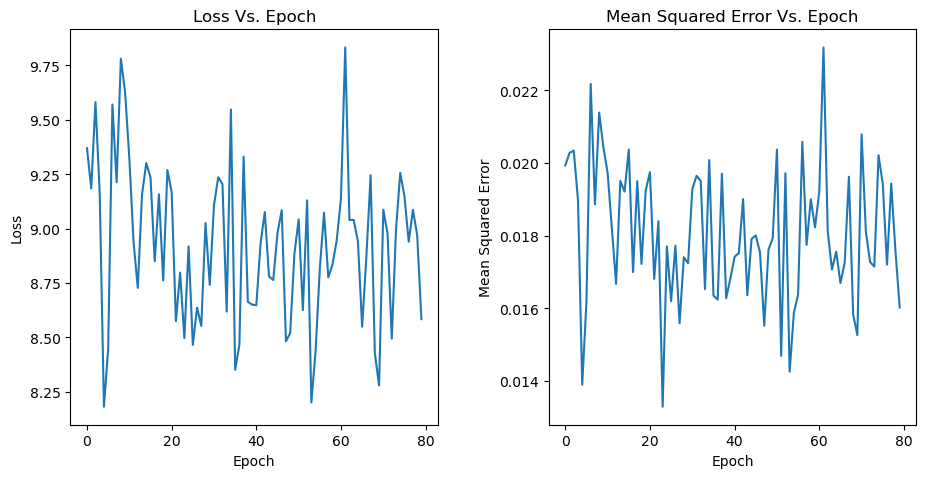

In [25]:
model1_loss = round((history1.history["loss"][model1_epochs - 1]), 3)
model1_mse = round((history1.history["mse"][model1_epochs - 1]), 3)
model1_train_time = round((endTime1 - startTime1) / 60, 3)

print("The final results for model 1:")
print(f"\nTraining Time = {model1_train_time} minutes")
print(f"Number of Epochs = {model1_epochs}")
print(f"Number of Steps per Epoch = {model1_steps}")
print(f"Loss = {model1_loss}")
print(f"Mean Squared Error = {model1_mse}\n")

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 2)
figure.tight_layout(pad = 2)
#figure.set_figheight(10)
figure.set_figwidth(10)

# Make a nice visualization of our test model: Training Loss Vs. Epoch
testLosses = history1.history["loss"]
epochs = [i for i in range(len(testLosses))]
axis[0].plot(epochs, testLosses)
axis[0].set_xlabel("Epoch")
axis[0].set_ylabel("Loss")
axis[0].set_title("Loss Vs. Epoch")

# Make another nice visualization: Loss Vs. Epoch
testError = history1.history["mse"]
axis[1].plot(epochs, testError)
axis[1].set_xlabel("Epoch")
axis[1].set_ylabel("Mean Squared Error")
axis[1].set_title("Mean Squared Error Vs. Epoch")

We will now save a local copy of the model and weights.

In [26]:
save_mod(model1, "weights/model1_weights.h5","models/Model1.json")

### Model 2

For this second of three models, we will again deploy the same basic frontend and backend structure as model 1. However we will deploy the changes from the second model from the CSRNet paper. For this model 1, dilation rate was increased to 2 for all layers of the backend except the final layer. This final layer continued to have a dilation rate of 1. These are the settings:

* Dilation Rate = 2 (except for final layer)
* Optimizer = SGD
* Learning Rate = 1e-6
* Weight Decay = 5e-4
* Momentum = 0.95
* Loss = Euclidean Distance Loss

Lastly, note that for all three models, the steps per epoch have been manually set to the length of the training data (700). If this is not set, it will seemingly continue to step to infinity (or a number so big that it is not worth testing).

In [27]:
# Neural network model : VGG + Conv
def CSRNet_2():  
    #Variable Input Size
    rows = None
    cols = None
            
    kernel = (3, 3)
    init = RandomNormal(stddev = 0.01)
    model = Sequential() 
            
    #custom VGG:
            
    model.add(Conv2D(filters = 64, kernel_size = kernel, activation = 'relu', padding='same', input_shape = (rows, cols, 3), kernel_initializer = init))
    model.add(Conv2D(filters = 64, kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
    model.add(MaxPooling2D(strides = 2))
    model.add(Conv2D(filters = 128, kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
    model.add(Conv2D(filters = 128, kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
    model.add(MaxPooling2D(strides = 2))
    model.add(Conv2D(filters = 256, kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
    model.add(Conv2D(filters = 256, kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
    model.add(Conv2D(filters = 256, kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
    model.add(MaxPooling2D(strides = 2))            
    model.add(Conv2D(filters = 512, kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
    model.add(Conv2D(filters = 512, kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
    model.add(Conv2D(filters = 512, kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                            
    #Conv2D
    model.add(Conv2D(filters = 512, kernel_size = (3, 3), activation = 'relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
    model.add(Conv2D(filters = 512, kernel_size = (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
    model.add(Conv2D(filters = 512, kernel_size = (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
    model.add(Conv2D(filters = 256, kernel_size = (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
    model.add(Conv2D(filters = 1, kernel_size = (1, 1), activation='relu', dilation_rate = 1, kernel_initializer = init, padding = 'same'))
        
    sgd = SGD(learning_rate = 1e-6, weight_decay = (5*1e-4), momentum = 0.95)
            
    model.compile(optimizer=sgd, loss=euclidean_distance_loss, metrics=['mse'])
    
    # Use pre-trained VGG16 weights
    model = init_weights_vgg(model)
            
    return model

In [28]:
model2 = CSRNet_2()
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, None, None, 64)    1792      
                                                                 
 conv2d_18 (Conv2D)          (None, None, None, 64)    36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, None, None, 64)   0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, None, None, 128)   73856     
                                                                 
 conv2d_20 (Conv2D)          (None, None, None, 128)   147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, None, None, 128)  0         
 2D)                                                  

In [29]:
model2_epochs = 80
model2_steps = len(train_paths)

startTime2 = time.time()
history2 = model2.fit(train_gen, epochs = model2_epochs, steps_per_epoch = model2_steps, verbose = 1)
endTime2 = time.time()

Epoch 1/80
700/700 [==============================] - 334s 468ms/step - loss: 8.9509 - mse: 0.0176
Epoch 2/80
700/700 [==============================] - 252s 361ms/step - loss: 9.1587 - mse: 0.0195
Epoch 3/80
700/700 [==============================] - 322s 460ms/step - loss: 9.0463 - mse: 0.0174
Epoch 4/80
700/700 [==============================] - 340s 487ms/step - loss: 9.7504 - mse: 0.0203
Epoch 5/80
700/700 [==============================] - 222s 316ms/step - loss: 9.5396 - mse: 0.0234
Epoch 6/80
700/700 [==============================] - 218s 311ms/step - loss: 9.3123 - mse: 0.0192
Epoch 7/80
700/700 [==============================] - 220s 314ms/step - loss: 9.1892 - mse: 0.0205
Epoch 8/80
700/700 [==============================] - 244s 349ms/step - loss: 8.5619 - mse: 0.0172
Epoch 9/80
700/700 [==============================] - 243s 347ms/step - loss: 9.4476 - mse: 0.0206
Epoch 10/80
700/700 [==============================] - 222s 318ms/step - loss: 9.1757 - mse: 0.0179
Epoch 11/

The final results for model 2:

Training Time = 346.418 minutes
Number of Epochs = 80
Number of Steps per Epoch = 700
Loss = 8.521
Mean Squared Error = 0.016



Text(0.5, 1.0, 'Mean Squared Error Vs. Epoch')

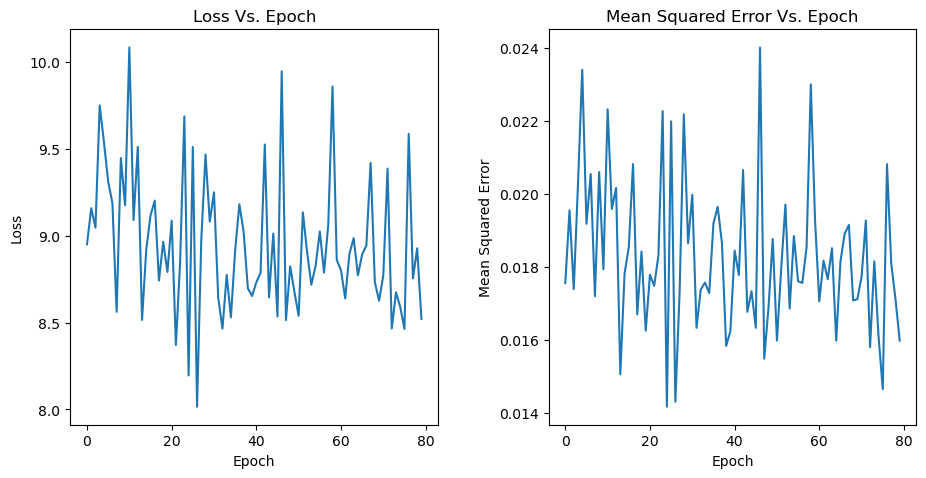

In [30]:
model2_loss = round((history2.history["loss"][model2_epochs - 1]), 3)
model2_mse = round((history2.history["mse"][model2_epochs - 1]), 3)
model2_train_time = round((endTime2 - startTime2) / 60, 3)

print("The final results for model 2:")
print(f"\nTraining Time = {model2_train_time} minutes")
print(f"Number of Epochs = {model2_epochs}")
print(f"Number of Steps per Epoch = {model2_steps}")
print(f"Loss = {model2_loss}")
print(f"Mean Squared Error = {model2_mse}\n")

figure, axis = plt.subplots(1, 2)
figure.tight_layout(pad = 2)
#figure.set_figheight(10)
figure.set_figwidth(10)

testLosses = history2.history["loss"]
epochs = [i for i in range(len(testLosses))]
axis[0].plot(epochs, testLosses)
axis[0].set_xlabel("Epoch")
axis[0].set_ylabel("Loss")
axis[0].set_title("Loss Vs. Epoch")

testError = history2.history["mse"]
axis[1].plot(epochs, testError)
axis[1].set_xlabel("Epoch")
axis[1].set_ylabel("Mean Squared Error")
axis[1].set_title("Mean Squared Error Vs. Epoch")

We will now save a local copy of the model and weights.

In [31]:
save_mod(model2, "weights/model2_weights.h5","models/Model2.json")

### Model 3

For our final model of three, we will do some light hyperparameter tuning. We will use the same exact structure as model 2. However, we will increase the learning rate. This actually goes against the recommendation of the CSRNet paper. So let us see what results we will get. Again, the below settings have been deployed:

* Dilation Rate = 2 (except for final layer)
* Optimizer = SGD
* Learning Rate = 1e-4
* Weight Decay = 5e-4
* Momentum = 0.95
* Loss = Euclidean Distance Loss

In [32]:
# Neural network model : VGG + Conv
def CSRNet_3():  
    #Variable Input Size
    rows = None
    cols = None
            
    kernel = (3, 3)
    init = RandomNormal(stddev = 0.01)
    model = Sequential() 
            
    #custom VGG:
            
    model.add(Conv2D(filters = 64, kernel_size = kernel, activation = 'relu', padding='same', input_shape = (rows, cols, 3), kernel_initializer = init))
    model.add(Conv2D(filters = 64, kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
    model.add(MaxPooling2D(strides = 2))
    model.add(Conv2D(filters = 128, kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
    model.add(Conv2D(filters = 128, kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
    model.add(MaxPooling2D(strides = 2))
    model.add(Conv2D(filters = 256, kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
    model.add(Conv2D(filters = 256, kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
    model.add(Conv2D(filters = 256, kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
    model.add(MaxPooling2D(strides = 2))            
    model.add(Conv2D(filters = 512, kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
    model.add(Conv2D(filters = 512, kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
    model.add(Conv2D(filters = 512, kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                            
    #Conv2D
    model.add(Conv2D(filters = 512, kernel_size = (3, 3), activation = 'relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
    model.add(Conv2D(filters = 512, kernel_size = (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
    model.add(Conv2D(filters = 512, kernel_size = (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
    model.add(Conv2D(filters = 256, kernel_size = (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
    model.add(Conv2D(filters = 1, kernel_size = (1, 1), activation='relu', dilation_rate = 1, kernel_initializer = init, padding = 'same'))
        
    sgd = SGD(learning_rate = 1e-4, weight_decay = (5*1e-4), momentum = 0.95)
            
    model.compile(optimizer=sgd, loss=euclidean_distance_loss, metrics=['mse'])
    
    # Use pre-trained VGG16 weights
    model = init_weights_vgg(model)
            
    return model

In [33]:
model3 = CSRNet_3()
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, None, None, 64)    1792      
                                                                 
 conv2d_35 (Conv2D)          (None, None, None, 64)    36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, None, None, 64)   0         
 2D)                                                             
                                                                 
 conv2d_36 (Conv2D)          (None, None, None, 128)   73856     
                                                                 
 conv2d_37 (Conv2D)          (None, None, None, 128)   147584    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, None, None, 128)  0         
 2D)                                                  

In [34]:
model3_epochs = 80
model3_steps = len(train_paths)

startTime3 = time.time()
history3 = model3.fit(train_gen, epochs = model3_epochs, steps_per_epoch = model3_steps, verbose = 1)
endTime3 = time.time()

Epoch 1/80
700/700 [==============================] - 209s 292ms/step - loss: 9.3865 - mse: 0.0201
Epoch 2/80
700/700 [==============================] - 207s 295ms/step - loss: 8.9825 - mse: 0.0187
Epoch 3/80
700/700 [==============================] - 207s 296ms/step - loss: 10.0358 - mse: 0.0226
Epoch 4/80
700/700 [==============================] - 205s 293ms/step - loss: 9.6981 - mse: 0.0227
Epoch 5/80
700/700 [==============================] - 204s 291ms/step - loss: 9.4561 - mse: 0.0201
Epoch 6/80
700/700 [==============================] - 205s 292ms/step - loss: 9.6865 - mse: 0.0206
Epoch 7/80
700/700 [==============================] - 207s 295ms/step - loss: 9.2439 - mse: 0.0189
Epoch 8/80
700/700 [==============================] - 205s 293ms/step - loss: 9.3605 - mse: 0.0209
Epoch 9/80
700/700 [==============================] - 206s 294ms/step - loss: 9.2378 - mse: 0.0201
Epoch 10/80
700/700 [==============================] - 211s 301ms/step - loss: 9.1903 - mse: 0.0193
Epoch 11

The final results for model 3:

Training Time = 264.75 minutes
Number of Epochs = 80
Number of Steps per Epoch = 700
Loss = 10.125
Mean Squared Error = 0.022



Text(0.5, 1.0, 'Mean Squared Error Vs. Epoch')

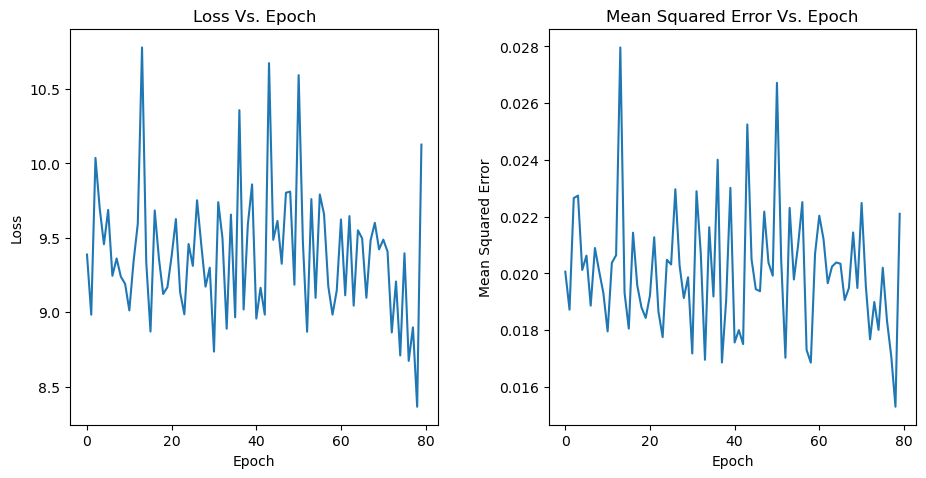

In [35]:
model3_loss = round((history3.history["loss"][model3_epochs - 1]), 3)
model3_mse = round((history3.history["mse"][model3_epochs - 1]), 3)
model3_train_time = round((endTime3 - startTime3) / 60, 3)

print("The final results for model 3:")
print(f"\nTraining Time = {model3_train_time} minutes")
print(f"Number of Epochs = {model3_epochs}")
print(f"Number of Steps per Epoch = {model3_steps}")
print(f"Loss = {model3_loss}")
print(f"Mean Squared Error = {model3_mse}\n")

figure, axis = plt.subplots(1, 2)
figure.tight_layout(pad = 2)
#figure.set_figheight(10)
figure.set_figwidth(10)

testLosses = history3.history["loss"]
epochs = [i for i in range(len(testLosses))]
axis[0].plot(epochs, testLosses)
axis[0].set_xlabel("Epoch")
axis[0].set_ylabel("Loss")
axis[0].set_title("Loss Vs. Epoch")

testError = history3.history["mse"]
axis[1].plot(epochs, testError)
axis[1].set_xlabel("Epoch")
axis[1].set_ylabel("Mean Squared Error")
axis[1].set_title("Mean Squared Error Vs. Epoch")

We will now save a local copy of the model and weights.

In [36]:
save_mod(model3, "weights/model3_weights.h5","models/Model3.json")

## Part 4: Results and Analysis

We have now built our models. Of note is that all three during training seemed to have loss and MSE that jumped around a little bit during the 80 epochs. However the end results are what we are most concerned with. Thus, we will now use all three to make some predictions on the test dataset. We will generate a head count and see if the prediction is close to the true count.

In [37]:
# Note this function was only used for testing.
def load_model():
    json_file = open('models/Model2.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("weights/model2_weights.h5")
    return loaded_model

Slightly modified image load function from earlier. This is designed specifically to load, normalize and return an image for our prediction function. 

In [38]:
def create_test_img(path):
    print(f"Image path = {path}\n")
    img = Image.open(path).convert('RGB')

    img = np.array(img)
    
    img = img / 255.0
    img[:, :, 0] = (img[:, :, 0] - np.mean(img[:, :, 0])) / np.std(img[:, :, 0])
    img[:, :, 1] = (img[:, :, 1] - np.mean(img[:, :, 1])) / np.std(img[:, :, 1])
    img[:, :, 2] = (img[:, :, 2] - np.mean(img[:, :, 2])) / np.std(img[:, :, 2])

    img = np.expand_dims(img, axis = 0)
    return img

This is our prediction function. It will load an image from a path, predict the heat map and generate a count.

In [39]:
def predict(path, model):
    #model = load_model()
    image = create_test_img(path)
    ans = model.predict(image)
    count = np.sum(ans)
    return count, image, ans

Now let us look at a sample test image from the large crowd data set. We will observe the heat maps and the predicted counts for each model.

Image path = data/large_crowd/test_data/images/IMG_118.jpg

1/1 [==============================] - 1s 987ms/step
Image path = data/large_crowd/test_data/images/IMG_118.jpg

1/1 [==============================] - 0s 284ms/step
Image path = data/large_crowd/test_data/images/IMG_118.jpg

1/1 [==============================] - 0s 296ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).




Large Crowd Count Example Prediction:

Model 1 Count = 233.9605712890625
Model 2 Count = 260.998291015625
Model 3 Count = 0.0
True Count = 238



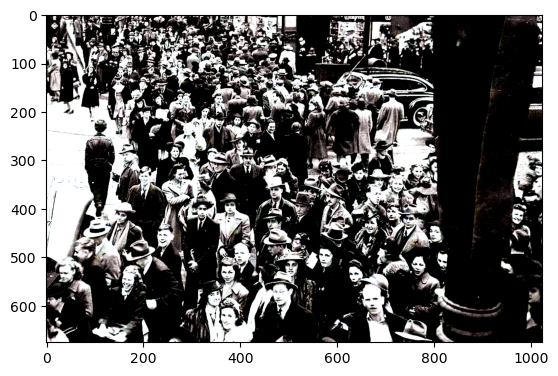

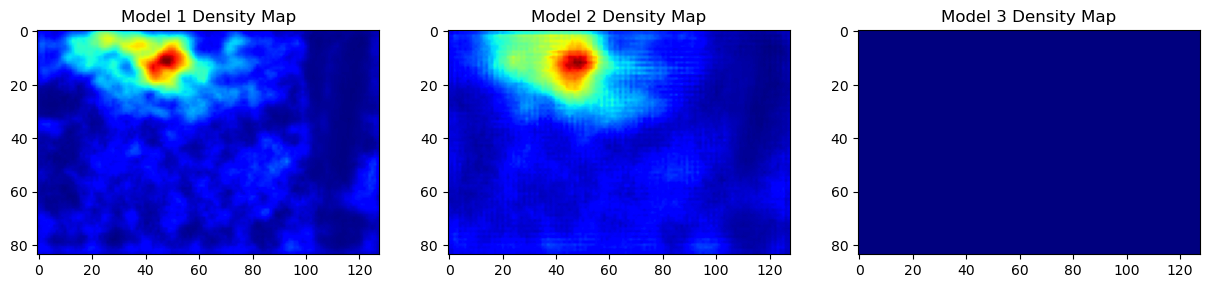

In [40]:
ans_l1, img_l1, hmap_l1 = predict('data/large_crowd/test_data/images/IMG_118.jpg', model1)
ans_l2, img_l2, hmap_l2 = predict('data/large_crowd/test_data/images/IMG_118.jpg', model2)
ans_l3, img_l3, hmap_l3 = predict('data/large_crowd/test_data/images/IMG_118.jpg', model3)

print("\n\nLarge Crowd Count Example Prediction:\n")
print(f"Model 1 Count = {ans_l1}")
print(f"Model 2 Count = {ans_l2}")
print(f"Model 3 Count = {ans_l3}")
gt1 = h5py.File('data/large_crowd/test_data/ground-truth/IMG_118.h5', 'r')
temp_1 = np.asarray(gt1['density'])
print(f"True Count = {int(np.sum(temp_1)) + 1}\n")

plt.imshow(img_l1.reshape(img_l1.shape[1], img_l1.shape[2], img_l1.shape[3]))
plt.show()

figure, axis = plt.subplots(1, 3)
figure.set_figheight(15)
figure.set_figwidth(15)
axis[0].set_title("Model 1 Density Map")
axis[0].imshow(hmap_l1.reshape(hmap_l1.shape[1], hmap_l1.shape[2]), cmap = CM.jet)
axis[1].set_title("Model 2 Density Map")
axis[1].imshow(hmap_l2.reshape(hmap_l2.shape[1], hmap_l2.shape[2]), cmap = CM.jet)
axis[2].set_title("Model 3 Density Map")
axis[2].imshow(hmap_l3.reshape(hmap_l3.shape[1], hmap_l3.shape[2]), cmap = CM.jet)

Next, we will look at a sample image from the small crowd dataset.

Image path = data/small_crowd/test_data/images/IMG_120.jpg

1/1 [==============================] - 0s 38ms/step
Image path = data/small_crowd/test_data/images/IMG_120.jpg

1/1 [==============================] - 0s 42ms/step
Image path = data/small_crowd/test_data/images/IMG_120.jpg

1/1 [==============================] - 0s 42ms/step


Small Crowd Count Example Prediction:

Model 1 Count = 35.55717468261719
Model 2 Count = 49.047874450683594
Model 3 Count = 0.0
True Count = 64



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


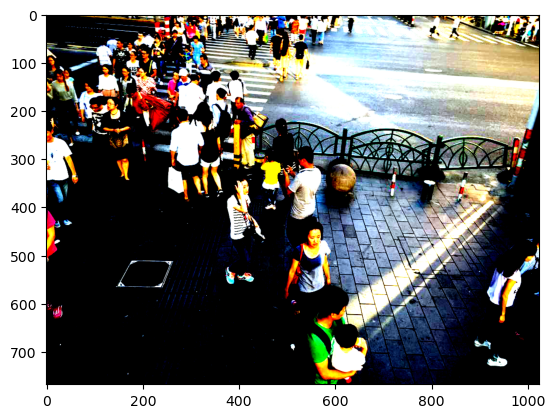

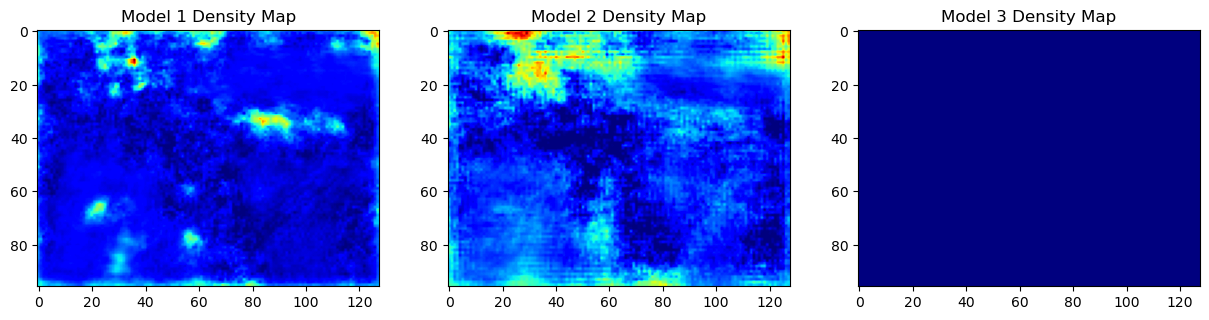

In [50]:
ans_s1, img_s1, hmap_s1 = predict('data/small_crowd/test_data/images/IMG_120.jpg', model1)
ans_s2, img_s2, hmap_s2 = predict('data/small_crowd/test_data/images/IMG_120.jpg', model2)
ans_s3, img_s3, hmap_s3 = predict('data/small_crowd/test_data/images/IMG_120.jpg', model3)

print("\n\nSmall Crowd Count Example Prediction:\n")
print(f"Model 1 Count = {ans_s1}")
print(f"Model 2 Count = {ans_s2}")
print(f"Model 3 Count = {ans_s3}")
gt1 = h5py.File('data/small_crowd/test_data/ground-truth/IMG_120.h5', 'r')
temp_1 = np.asarray(gt1['density'])
print(f"True Count = {int(np.sum(temp_1)) + 1}\n")

plt.imshow(img_s1.reshape(img_s1.shape[1], img_s1.shape[2], img_s1.shape[3]))
plt.show()

figure, axis = plt.subplots(1, 3)
figure.set_figheight(15)
figure.set_figwidth(15)
axis[0].set_title("Model 1 Density Map")
axis[0].imshow(hmap_s1.reshape(hmap_s1.shape[1], hmap_s1.shape[2]), cmap = CM.jet)
axis[1].set_title("Model 2 Density Map")
axis[1].imshow(hmap_s2.reshape(hmap_s2.shape[1], hmap_s2.shape[2]), cmap = CM.jet)
axis[2].set_title("Model 3 Density Map")
axis[2].imshow(hmap_s3.reshape(hmap_s3.shape[1], hmap_s3.shape[2]), cmap = CM.jet)

Let us now generate separate test sets for both the large and small crowd imagery.

In [42]:
lg_crowd_test_set = [large_crowd_test]
sm_crowd_test_set = [small_crowd_test]

lg_crowd_img_paths = []
for path in lg_crowd_test_set:
    for lg_crowd_img_path in glob.glob(os.path.join(path, '*.jpg')):
        lg_crowd_img_paths.append(lg_crowd_img_path)
print(f"Number of Large Crowd Images = {len(lg_crowd_img_paths)}")

sm_crowd_img_paths = []
for path in sm_crowd_test_set:
    for sm_crowd_img_path in glob.glob(os.path.join(path, '*.jpg')):
        sm_crowd_img_paths.append(sm_crowd_img_path)
print(f"Number of Small Crowd Images = {len(sm_crowd_img_paths)}")

Number of Large Crowd Images = 182
Number of Small Crowd Images = 316


Now let make predictions for the entire datasets. Separate predictions will be made for the large and small crowd datasets. All 3 models will be tested. 

In [43]:
# 1) Loop through the large crowd test data
large_crowd_name = []
large_crowd_y_true = []
large_crowd_y_pred1 = []
large_crowd_y_pred2 = []
large_crowd_y_pred3 = []

print("*** Begin Large Crowd Prediction Loop. ***")
for image in lg_crowd_img_paths:
    large_crowd_name.append(image)
    file_path = image.replace('.jpg','.h5').replace('images','ground-truth')
    gt = h5py.File(file_path, 'r')
    groundtruth = np.asarray(gt['density'])    
    count = np.sum(groundtruth)
    large_crowd_y_true.append(np.sum(count))
    img = create_test_img(image)
    num1 = np.sum(model1.predict(img))
    num2 = np.sum(model2.predict(img))
    num3 = np.sum(model3.predict(img))
    large_crowd_y_pred1.append(np.sum(num1))
    large_crowd_y_pred2.append(np.sum(num2))
    large_crowd_y_pred3.append(np.sum(num3))

large_crowd_data1 = pd.DataFrame({'name': large_crowd_name,'y_pred': large_crowd_y_pred1,'y_true': large_crowd_y_true})
large_crowd_data2 = pd.DataFrame({'name': large_crowd_name,'y_pred': large_crowd_y_pred2,'y_true': large_crowd_y_true})
large_crowd_data3 = pd.DataFrame({'name': large_crowd_name,'y_pred': large_crowd_y_pred3,'y_true': large_crowd_y_true})
print("*** End Large Crowd Prediction Loop ***")


# 2) Loop through the small crowd test data
small_crowd_name = []
small_crowd_y_true = []
small_crowd_y_pred1 = []
small_crowd_y_pred2 = []
small_crowd_y_pred3 = []

print("\n*** Begin Small Crowd Prediction Loop ***")
for image in sm_crowd_img_paths:
    small_crowd_name.append(image)
    file_path = image.replace('.jpg','.h5').replace('images','ground-truth')
    gt = h5py.File(file_path, 'r')
    groundtruth = np.asarray(gt['density'])    
    count = np.sum(groundtruth)
    small_crowd_y_true.append(np.sum(count))
    img = create_test_img(image)
    num1 = np.sum(model1.predict(img))
    num2 = np.sum(model2.predict(img))
    num3 = np.sum(model3.predict(img))
    small_crowd_y_pred1.append(np.sum(num1))
    small_crowd_y_pred2.append(np.sum(num2))
    small_crowd_y_pred3.append(np.sum(num3))

small_crowd_data1 = pd.DataFrame({'name': small_crowd_name,'y_pred': small_crowd_y_pred1,'y_true': small_crowd_y_true})
small_crowd_data2 = pd.DataFrame({'name': small_crowd_name,'y_pred': small_crowd_y_pred2,'y_true': small_crowd_y_true})
small_crowd_data3 = pd.DataFrame({'name': small_crowd_name,'y_pred': small_crowd_y_pred3,'y_true': small_crowd_y_true})
print("*** End Small Crowd Prediction Loop ***")

*** Begin Large Crowd Prediction Loop. ***
Image path = data/large_crowd/test_data/images/IMG_131.jpg

1/1 [==============================] - 0s 44ms/step
Image path = data/large_crowd/test_data/images/IMG_163.jpg

1/1 [==============================] - 1s 717ms/step
Image path = data/large_crowd/test_data/images/IMG_173.jpg

1/1 [==============================] - 0s 48ms/step
Image path = data/large_crowd/test_data/images/IMG_161.jpg

1/1 [==============================] - 0s 43ms/step
Image path = data/large_crowd/test_data/images/IMG_85.jpg

1/1 [==============================] - 0s 45ms/step
Image path = data/large_crowd/test_data/images/IMG_38.jpg

1/1 [==============================] - 0s 44ms/step
Image path = data/large_crowd/test_data/images/IMG_40.jpg

1/1 [==============================] - 0s 49ms/step
Image path = data/large_crowd/test_data/images/IMG_25.jpg

1/1 [==============================] - 0s 42ms/step
Image path = data/large_crowd/test_data/images/IMG_116.jpg

1/1 

We will now take a look at the final mean absolute error for all three models with the large crowd dataset.

Final Large Crowd Mean Absolute Error:
Model 1 = 189.7840118408203
Model 2 = 147.4353790283203
Model 3 = 428.88848876953125



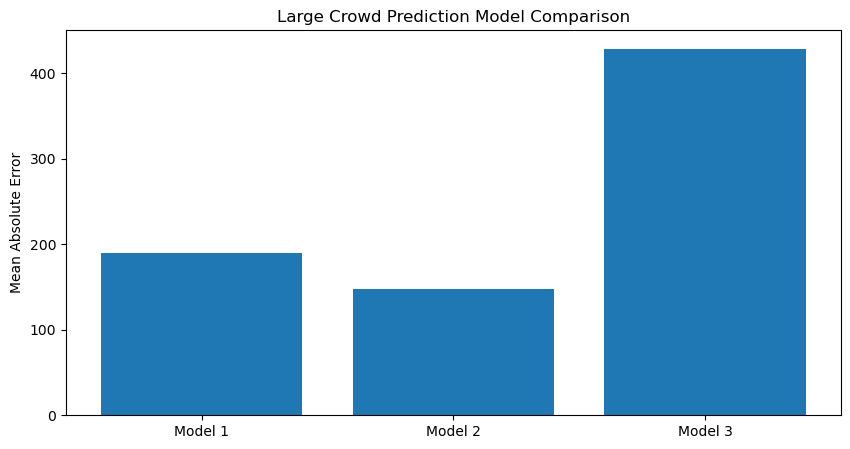

In [44]:
lg_y_true = large_crowd_data1['y_true']
lg_y_pred1 = large_crowd_data1['y_pred']
lg_y_pred2 = large_crowd_data2['y_pred']
lg_y_pred3 = large_crowd_data3['y_pred']

lg_ans1 = mean_absolute_error(np.array(lg_y_true),np.array(lg_y_pred1))
lg_ans2 = mean_absolute_error(np.array(lg_y_true),np.array(lg_y_pred2))
lg_ans3 = mean_absolute_error(np.array(lg_y_true),np.array(lg_y_pred3))

print("Final Large Crowd Mean Absolute Error:")
print(f"Model 1 = {lg_ans1}")
print(f"Model 2 = {lg_ans2}")
print(f"Model 3 = {lg_ans3}\n")

height = [lg_ans1, lg_ans2, lg_ans3]
bars = ('Model 1', 'Model 2', 'Model 3')
x_pos = np.arange(len(bars))

fig = plt.figure(figsize = (10, 5))
plt.bar(x_pos, height)
plt.xticks(x_pos, bars)
plt.ylabel("Mean Absolute Error")
plt.title("Large Crowd Prediction Model Comparison")

plt.show()

Let us take a look at the mean square error results for the small crowd dataset. Again we will be comparing all 3 models.

Final Small Crowd Mean Absolute Error:
Model 1 = 70.49314880371094
Model 2 = 56.98896026611328
Model 3 = 119.77305603027344



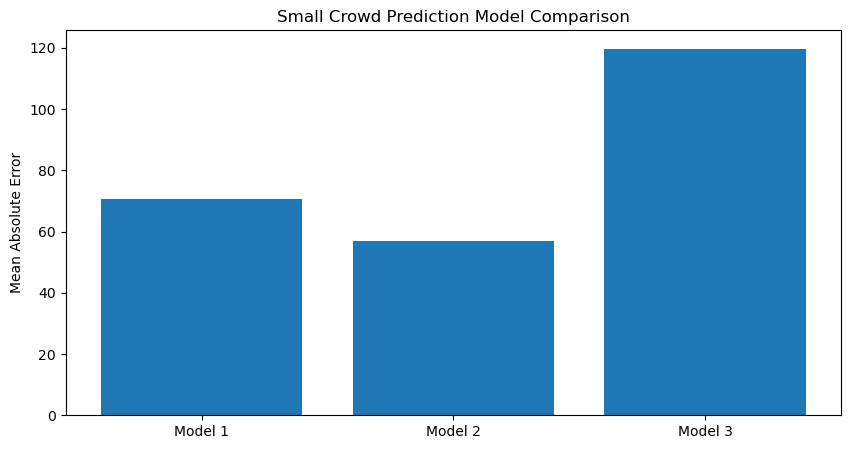

In [45]:
sm_y_true = small_crowd_data1['y_true']
sm_y_pred1 = small_crowd_data1['y_pred']
sm_y_pred2 = small_crowd_data2['y_pred']
sm_y_pred3 = small_crowd_data3['y_pred']

sm_ans1 = mean_absolute_error(np.array(sm_y_true),np.array(sm_y_pred1))
sm_ans2 = mean_absolute_error(np.array(sm_y_true),np.array(sm_y_pred2))
sm_ans3 = mean_absolute_error(np.array(sm_y_true),np.array(sm_y_pred3))

print("Final Small Crowd Mean Absolute Error:")
print(f"Model 1 = {sm_ans1}")
print(f"Model 2 = {sm_ans2}")
print(f"Model 3 = {sm_ans3}\n")

height = [sm_ans1, sm_ans2, sm_ans3]
bars = ('Model 1', 'Model 2', 'Model 3')
x_pos = np.arange(len(bars))

fig = plt.figure(figsize = (10, 5))
plt.bar(x_pos, height)
plt.xticks(x_pos, bars)
plt.ylabel("Mean Absolute Error")
plt.title("Small Crowd Prediction Model Comparison")

plt.show()

To recap, let us look at a comparison of the 3 models. The following are some observations of note:

* Model 2 seems to be the superior model with both datasets base on mean absolute error. Model 1 is next best. 
* In my own personal testing, in terms of the small crowd datasets, the counts are closer to truth when the true count is below 80. When the count is above this, both models struggle.
* Model 3 did not work at all. Recall that this model was identical to model except the learning rate was increased. Increasing the learning rate was going against the recommendation of the paper. It does not produce any results at all. Note that during my testing model 3 seemed to have similar results to model 2 but with a lower epoch count for training.
* Overall, the results were okay. We got reasonably close counts but definitely not close to the mean absolute error results from the paper. Of note is that the paper does mentioned they trained their models over 200 epochs. However these models were extremly slow to train. Thus, either more training time or a better test system would be necessary.

## Part 5: Conclusion

The CSRNet had reasonable results in the end. It was able to produce heat maps and decently close counts for crowd sizes. In my testing, it did fairly well with the large crowd set. It also did good with the small crowd set if the true count was approximately less than 80. Above that, both models 1 and 2 would have significant inaccuracy. 

Model 2 did give the best results. Setting dilation to a value of 2 on the ANN was the key difference. 

Model 3 had disastrous results and was basically broken. This model had an increased learning rate. What my guess for this failure would be that we are using transfer learning with a pre-trained VGG16 model. By having a learning rate that is too high, it breaks the VGG16 model. 

To conclude, below are some key points that were observed in building this model:

* Dilation rate seemed to improve performance. However, of note from the paper, perhaps increasing it too much will have negative effects. A value of 2 appears to be best.
* Ensure to manually set the steps per epoch, or it will seemingly step forever. In our models, this was set to the number of training samples (700).
* In experimenting with the models, increasing the number of epochs did show benefits. However, the time needed to train is extremely significant. This notebook was tested on a computer with a single GPU. Upgrading this setup will allow for more experimentation.
* Absolutely do not increase the learning rate hyperparameter.

Lastly, note that although the data was hosted on Kaggle, this is not a hosted competition. However, the final results will be exported for upload onto GitHub.

In [46]:
large_crowd_data1.to_csv('CSV/Model1_Lg_Test.csv', sep=',')
large_crowd_data1.to_csv('CSV/Model2_Lg_Test.csv', sep=',')
large_crowd_data1.to_csv('CSV/Model3_Lg_Test.csv', sep=',')

small_crowd_data1.to_csv('CSV/Model1_Sm_Test.csv', sep=',')
small_crowd_data1.to_csv('CSV/Model2_Sm_Test.csv', sep=',')
small_crowd_data1.to_csv('CSV/Model3_Sm_Test.csv', sep=',')

##  Part 6: Reference

* https://openaccess.thecvf.com/content_cvpr_2018/papers/Li_CSRNet_Dilated_Convolutional_CVPR_2018_paper.pdf
* https://github.com/Neerajj9/CSRNet-keras
* https://colab.research.google.com/drive/1gAsWhDztBLu--1xcz11inY1JepSEan3X#scrollTo=DPmTIVQ9Tnys
* https://www.bmvc2020-conference.com/assets/papers/0368.pdf